In [2]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.metrics import f1_score

In [3]:
#reading graph
#if we don't have train_woheader file we will create it by change one csv to another csv
if not os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('/content/drive/MyDrive/Facebook/data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


Weakly Connected conponent

A weakly connected component is a subgraph that is unreachable from other nodes/vertices of a graph or subgraph

In [4]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components wit 2 nodes',count)

No of weakly connected components 45558
weakly connected components wit 2 nodes 32195


Missing Edges

In [5]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('/content/drive/MyDrive/Facebook/data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('/content/drive/MyDrive/Facebook/data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('/content/drive/MyDrive/Facebook/data/after_eda/missing_edges_final.p','rb'))

CPU times: user 1.88 s, sys: 871 ms, total: 2.75 s
Wall time: 3.77 s


In [6]:
print(len(missing_edges))

9437519


Train and Test Split

In [ ]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('/content/drive/MyDrive/Facebook/data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    #X_train_pos.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    #X_test_pos.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    #X_train_neg.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    #X_test_neg.to_csv('/content/drive/MyDrive/Facebook/data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

In [3]:
if (os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Some Basic features

Jaccard Distance

In [4]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [5]:
print(jaccard_for_followees(273081,1505602))

0


In [6]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [7]:
print(jaccard_for_followers(273084,470294))

0


Cosine Distance

In [8]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [11]:
print(cosine_for_followees(132435,3748369))

0


In [9]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

In [13]:
print(cosine_for_followers(23455,27379))

0


Shortest path

In [14]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [15]:
print(compute_shortest_path_length(2,67474))

-1


Checking for same community

In [16]:
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [17]:
belongs_to_same_wcc(861, 1659750)

0

Adamic/Adar Index

In [18]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

In [19]:
print(calc_adar_in(2,34879))

0


Is person Follow back

In [20]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [21]:
follows_back(1,189226)

1

Katz Centrality

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Facebook/data/fea_sample/katz.p.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('/content/drive/MyDrive/Facebook/data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('/content/drive/MyDrive/Facebook/data/fea_sample/katz.p','rb'))

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

In [ ]:
import random
if os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/train_after_eda.csv'):
    filename = "train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/test_after_eda.csv'):
    filename = "test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return  num_followers_s,num_followees_s,num_followers_d,num_followees_d,inter_followers,inter_followees

Weight Features

In [ ]:
#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in  tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

SVD features

In [ ]:
def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

In [ ]:
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

In [ ]:
from scipy.sparse.linalg import svds, eigs

In [ ]:
Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

In [ ]:
U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

In [4]:
df_final_train=read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5','train_df',mode='r')
df_final_test=read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5','test_df',mode='r')

In [5]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

Preferential_Attachment_Followers

In [6]:
def Preferential_Attachment_followers(a,b):
  try:
    if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
      return 0
    else :
      sco = len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))
      return sco
  except :
    return 0

In [7]:
print(Preferential_Attachment_followers(17562,67893))

3


Preferential_Attachment_Followeee

In [8]:
#for followee
def Preferential_Attachment_followee(a,b):
  try:
    if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
      return 0
    else :
      sco = len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
      return sco
  except:
    return 0

In [9]:
print(Preferential_Attachment_followee(356482,17893))

15


In [10]:
df_final_train['Preferential_Attachment_followers'] = df_final_train.apply(lambda row:
                                            Preferential_Attachment_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['Preferential_Attachment_followers'] = df_final_test.apply(lambda row:
                                            Preferential_Attachment_followers(row['source_node'],row['destination_node']),axis=1)

    #mapping Preferential_Attachment_followee to train and test data
df_final_train['Preferential_Attachment_followee'] = df_final_train.apply(lambda row:
                                            Preferential_Attachment_followee(row['source_node'],row['destination_node']),axis=1)
df_final_test['Preferential_Attachment_followee'] = df_final_test.apply(lambda row:
                                            Preferential_Attachment_followee(row['source_node'],row['destination_node']),axis=1)
    #adding SVD_DOT features of followers and followee
df_final_train['svd_dot_u']=(df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1'])+(df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2'])+(df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3'])+(df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4'])+(df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5'])+(df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6'])
df_final_train['svd_dot_v']=(df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1'])+(df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2'])+(df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3'])+(df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4'])+(df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5'])+(df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6'])
    #===================================================================================================
df_final_test['svd_dot_u']=(df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1'])+(df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2'])+(df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3'])+(df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4'])+(df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5'])+(df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6'])
df_final_test['svd_dot_v']=(df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1'])+(df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2'])+(df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3'])+(df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4'])+(df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5'])+(df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6'])

In [11]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'Preferential_Attachment_followers', 'Preferential_Attachment_followee',
       'svd_dot_u', 'svd_dot_v'],
      dtype='obje

In [12]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [13]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
Estimators =  50 Train Score 0.9675354922332259 test Score 0.9231354642313546
Estimators =  100 Train Score 0.9736268857840504 test Score 0.9281594571670908
Estimators =  250 Train Score 0.9779501631263698 test Score 0.9152513258755074
Estimators =  450 Train Score 0.9824526059189717 test Score 0.9005723238961547


Text(0.5, 1.0, 'Estimators vs score at depth of 3')

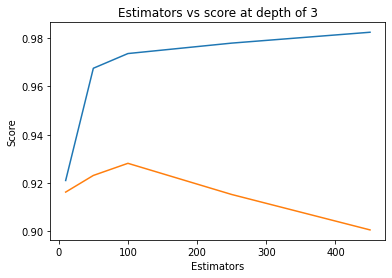

In [34]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=i, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 3')

depth =  4 Train Score 0.9248069538799106 test Score 0.9234347577865647
depth =  6 Train Score 0.9624685008999743 test Score 0.9283385539858083
depth =  8 Train Score 0.9719411363890612 test Score 0.9337135614702154
depth =  12 Train Score 0.9816578697243625 test Score 0.9344876980114594
depth =  15 Train Score 0.9887880405766151 test Score 0.9341272011950096
depth =  25 Train Score 0.995561878237174 test Score 0.9324673686865502
depth =  49 Train Score 0.9959742834825452 test Score 0.9326440115167182
depth =  52 Train Score 0.9959742834825452 test Score 0.9326440115167182
depth =  78 Train Score 0.9959742834825452 test Score 0.9326440115167182


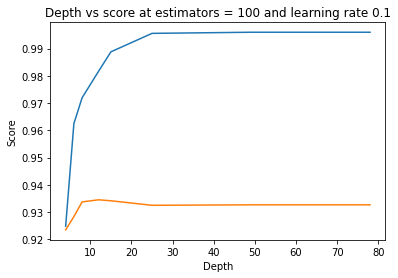

In [23]:
depths = [4,6,8,12,15,25,49,52,78]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=i, min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at estimators = 100 and learning rate 0.1')
plt.show()

learning rate =  0.1 Train Score 0.99527739063299 test Score 0.9271202632416942
learning rate =  0.2 Train Score 1.0 test Score 0.9266801146618537
learning rate =  0.4 Train Score 1.0 test Score 0.9263269639065816
learning rate =  0.8 Train Score 1.0 test Score 0.9244746338357037
learning rate =  0.9 Train Score 1.0 test Score 0.9243897261727871


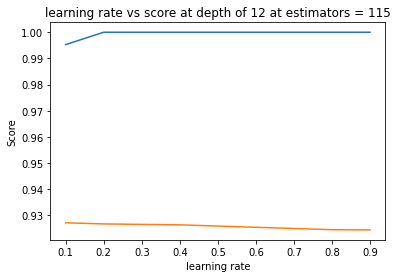

In [37]:
learningrate = [0.1,0.2,0.4,0.8,0.9]
train_scores = []
test_scores = []
for i in learningrate :
    clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=i,
       max_delta_step=0, max_depth=12, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('learning rate = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(learningrate,train_scores,label='Train Score')
plt.plot(learningrate,test_scores,label='Test Score')
plt.xlabel('learning rate')
plt.ylabel('Score')
plt.title('learning rate vs score at depth of 12 at estimators = 100')
plt.show()

In [15]:
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform


param_dist = {"n_estimators":sp_randint(70,125),
              "max_depth": sp_randint(10,15),
              "learning_rate": uniform(0,1)}

clf = XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98115563 0.98152528 0.97963401 0.98125051 0.98092199]
mean train scores [1.         1.         0.99831014 1.         1.        ]


In [16]:
print(rf_random.best_estimator_)

XGBClassifier(learning_rate=0.27883894070106907, max_depth=14, n_estimators=120,
              n_jobs=-1, random_state=25)


In [17]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=14, min_child_weight=1, missing=None,
       n_estimators=120, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [18]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [19]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9999600383631714
Test f1 score 0.9274790539823947


In [20]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


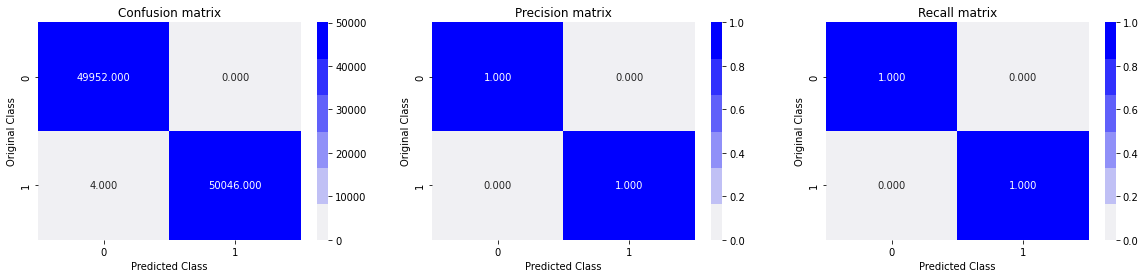

Test confusion_matrix


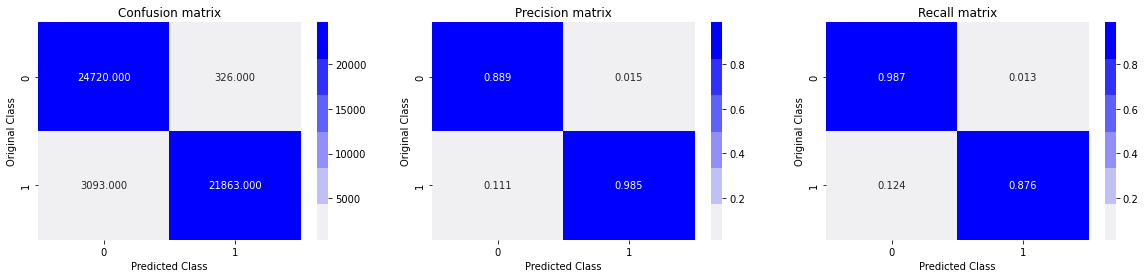

In [21]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

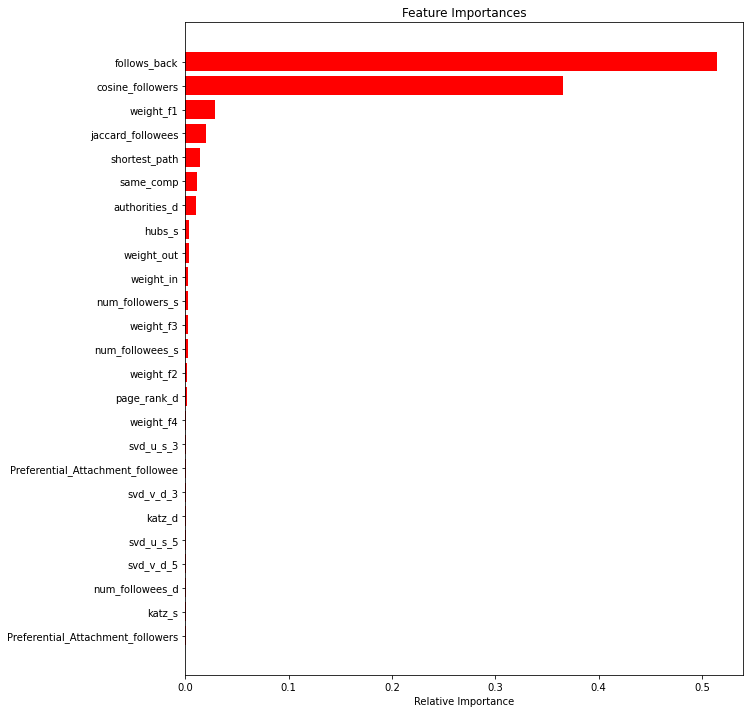

In [22]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Observation:
1. XGBoost perform better than random forest classifier as specified in reference document
2. follow back is most import features in the model 
3. As our problem statement required not to miss any connection so we are getting high recall for test data.
4. i used 3 hyperparameter for XGB as estimitor,depth and learninng rate and they are perfectly tuned for best result
5. In the newly added assignment features preferntial Attachment Followee is most useful feature as compair to PA followers and svd_dot

